# 12. 인공지능으로 세상에 없던 새로운 패션 만들기

## 프로젝트 : CIFAR-10 이미지 생성하기
GAN을 학습하는 과정은 보기보다 까다롭다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어보자.<br>
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있다.

* 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경된다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있다.
* 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경된다. 시각화 과정에서 고려할 점이 있다.
* 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라진다.

### STEP 0. 작업환경 구성하기
---
다음과 같이 작업환경을 구성하자.

```bash
$ mkdir -p ~/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/training_history
```

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### STEP 1. 데이터셋 구성하기
---
CIFAR-10 데이터셋도 `tf.keras` 안에 있는 `datasets`에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있다.

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

* 학습에 사용할 `train_x`의 이미지를 [-1, 1]로 정규화한다.
* 로드한 학습 데이터를 시각화를 통해 확인해보자.
* tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성한다.

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠준다.

In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

한번 첫 번째 데이터를 꺼내서 어떻게 생겼는지 확인해보자.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


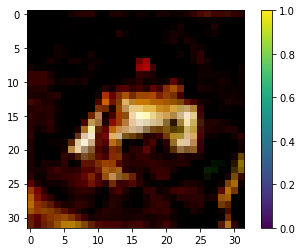

In [7]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

 for 문을 활용해서 이미지 25개를 5x5 의 배열로 띄워보자.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

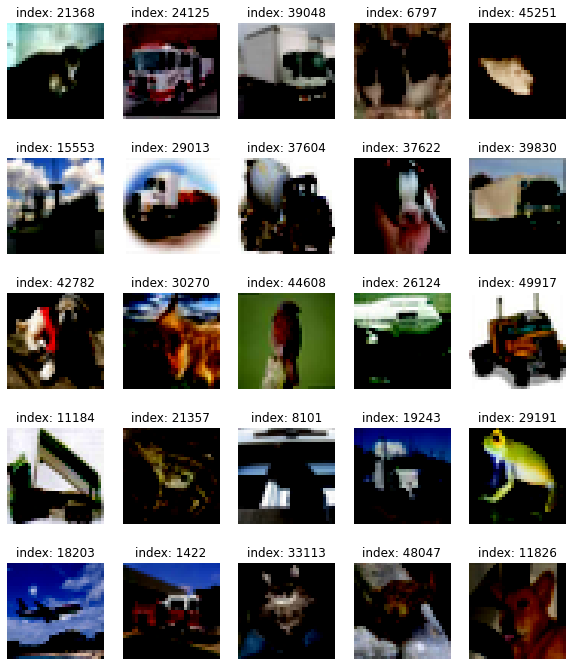

In [8]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3).astype('float32'))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

이렇게 정리된 데이터를 곧 모델에 넣어서 학습시켜야 하니, 편하게 사용할 수 있도록 텐서플로우의 `Dataset`을 이용해 준비해 놓도록 하자. 이를 이용하면 우리가 매번 모델에게 직접 섞어서 넣어주지 않아도 된다.

In [9]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

`BATCH_SIZE`는 모델이 한 번에 학습할 데이터의 양이다.<br>
너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행한다. 이러한 방식을 __미니배치 학습__이라고 한다.

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset 모듈의 `from_tensor_slices()` 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다.

### STEP 2. 생성자 모델 구현하기
* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해보자.
* `noise = tf.random.normal([1, 100])`로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해보자.
* 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해보자.

In [11]:
def make_generator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    
    return model

`make_generator_model`이라는 함수를 만들어서 언제든 생성자를 생성할 수 있도록 했다.

함수 내부에서는 먼저 `tf.keras.Sequential()`로 모델을 시작한 후 레이어를 차곡차곡 쌓아준다.

여기에서 가장 중요한 레이어는 바로 `Conv2DTranspose` 레이어이다. `Conv2DTranspose` 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층이다. 이 모델에서는 세 번의 `Conv2DTranspose` 층을 이용해 `(8, 8, 256) → (16, 16, 64) → (32, 32, 3)` 순으로 이미지를 키워나간다. 여기서 최종 사이즈인 `(32, 32, 3)`은 준비했던 데이터셋과 형상이 동일하다.

* 참고: [What is Transposed Convolutional Layer?](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11)

레이어의 사이사이에 특정 층들이 반복되는 것을 확인할 수 있는데, `BatchNormalization` 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜준다. 또한 중간층들의 활성화 함수는 모두 `LeakyReLU`를 사용하였다. 다만 마지막 층에는 활성화 함수로 `tanh`를 사용하는데, 이는 우리가 -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함이다.

* 참고: [라온피플-Batch Normalization](https://m.blog.naver.com/laonple/220808903260)
* 참고: [활성화 함수 (activation function)](https://newly0513.tistory.com/20)

모델 구조를 한번 자세히 살펴보자.

* 생성자의 입력 벡터 형태 : 모델은 입력값으로 (batch_size, 100) 형상의 노이즈 벡터를 받는다.
* 입력된 (batch_size, 100) 벡터는 8 x 8 x 256 = 16384개의 노드를 가진 첫 번째 Dense 레이어를 거치며 (batch_size, 16384) 형상의 벡터가 된다.
* 첫 번째 레이어를 지난 후 벡터는 Reshape 레이어를 지나게 된다.
    - 이는 이후의 Layer에서 Convolutional 연산을 할 수 있도록 1차원 벡터를 (8, 8, 256) 형상의 3차원 벡터로 변환시키는 작업이다.

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [13]:
noise = tf.random.normal([1, 100])

In [14]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

`[1, 32, 32, 3]` 사이즈의 이미지가 잘 생성되었다.<br>
첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻을 가진다.

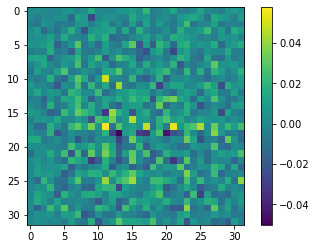

In [15]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

역시 -1과 1 사이의 값에서 적당히 잘 생성된 것을 확인할 수 있다.<br>
아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성되었지만, 모델이 점차 학습해 나가며 제대로 된 이미지를 생성할 수 있을 것이다.

### STEP 3. 판별자 모델 구현하기
---
* (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해보자.
* 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해보자.


In [16]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

판별자 또한 `make_discriminator_model` 함수로 구현하였다.

`Conv2DTranspose` 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 `Conv2D` 층으로 이미지의 크기를 점점 줄여나간다. <br>
첫 번째 Conv2D 층에서 입력된 `[32, 32, 3]` 사이즈의 이미지는 다음 층을 거치며 `(32, 32, 3) → (16, 16, 64) → (8, 8, 128)`까지 줄어들게 된다.

마지막에는 `Flatten` 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192, 즉 (1, 8192) 형상의 벡터로 변환한다. 이는 생성자의 `Reshape` 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 한다. 1차원 벡터로 변환한 후에는 마지막 `Dense` Layer를 거쳐 단 하나의 값을 출력하게 된다.

그럼 판별 모델을 `discriminator`라는 변수 이름으로 생성하고, 모델 세부 내용인 summary를 출력해보자.

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00321182]], dtype=float32)>


텐서플로우의 텐서 형태로 출력이 되었다. 이 값 또한 아직까진 아무런 의미가 없는 값이다.

그렇다면 이제 드디어 모델 학습을 위한 여정을 떠나보자.

### STEP 4. 손실함수와 최적화 함수 구현하기
---
* 생성자와 판별자의 손실함수(loss)를 구현해보자.
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해보자.
* 생성자와 판별자를 최적화하는 optimizer를 정의한다.

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용한다.

* `fake_output` : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 `D(fake_image)`
* `real_output` : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 `D(real_image)`

그럼 이제, `fake_output`과 `real_output`을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까?

바로 `tf.ones_like()`와 `tf.zeros_like()` 함수를 활용하면 된다

#### generator_loss

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### discriminator_loss

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### discriminator accuracy

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면 다음과 같다.

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

* (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
    - `>> tf.Tensor([False, False, True, True])`
* (2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
    - `>> tf.Tensor([0.0, 0.0, 1.0, 1.0])`
* (3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
    - `>> 0.5`

#### 최적화 함수(optimizer)
---
자.. 그럼 손실함수는 모두 설계가 되었고, 이제 최적화 함수를 설정할 차례이다. 이번에는 __Adam 최적화 기법__ 을 활용해 보자.

* 참고: [문과생도 이해하는 딥러닝 (8) - 신경망 학습 최적화](https://sacko.tistory.com/42)

Adam 함수 또한 `tf.keras.optimizers` 안에 있다.<br>
중요한 하이퍼 파라미터인 "learning rate"는 0.0002로 "momentum"은 0.5로 정하였다. 
[하이퍼 파라미터 참고 사이트](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

또한, 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다.

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

### STEP 5. 훈련과정 상세 기능 구현하기
---
* 1개 미니배치의 훈련 과정을 처리하는 `train_step()` 함수를 구현해보자.
* 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 `generate_and_save_images()` 함수를 구현해보자.
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 `draw_train_history()` 함수를 구현해보자.
* `training_checkpoints` 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해보자.

샘플은 한 번에 16장을 생성하도록 하겠다.<br>
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 한다.<br>
즉, 100차원의 노이즈를 총 16개, `(16, 100)` 형상의 벡터를 만들어 두도록 하자.

In [24]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [25]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

`train_step` 함수를 하나하나 뜯어보면 다음과 같다.

* (1) 입력데이터: Real Image 역할을 할 `images` 한 세트를 입력으로 받음
* (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 `noise`를 `images` 한 세트와 같은 크기인 `BATCH_SIZE` 만큼 생성함
* (3) `tf.GradientTape()`는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 `with` 구문 열기
* (4) generated_images 생성 : generator가 `noise`를 입력받은 후 `generated_images` 생성
* (5) discriminator 판별 : discriminator가 Real Image인 `images`와 Fake Image인 `generated_images`를 각각 입력받은 후 `real_output`, `fake_output` 출력
* (6) loss 계산 : `fake_output`, `real_output`으로 generator와 discriminator 각각의 loss 계산
* (7) accuracy 계산 : `fake_output`, `real_output`으로 discriminator가
* (8) gradient 계산 : `gen_tape`와 `disc_tape`를 활용해 gradient를 자동으로 계산
* (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
* (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

이러한 일련의 과정을 통해 한 번의 `train_step`이 끝나게 된다.

그러면, 이렇게 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들어 보자.<br>
아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있다.

In [26]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2) # 정규화 해주었다.
        plt.axis('off')

    plt.savefig('{}/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

학습 과정을 체크하기 위해 시각화해 보아야 할 중요한 것으로 loss와 accuracy 그래프를 빼놓을 수 없다. GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문이다. `train_step()` 함수가 리턴하는 `gen_loss`, `disc_loss`, `real_accuracy`, `fake_accuracy` 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어보자. 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리할 예정이다.

In [27]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

다음은 정기적으로 모델을 저장하기 위한 checkpoint를 만들어준다.

`tf.train.Checkpoint`를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다.

checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장한다. 정확히는 생성자와 구분자가 학습한 모델 가중치를 저장하는 것이다. 게임의 체크포인트처럼 학습 환경과 학습한 내용을 저장해둔다.

checkpoint 모델을 저장하기 위해 작업환경 내에 `training_checkpoints` 라는 디렉토리를 사용하자.

In [28]:
checkpoint_dir = os.getenv('HOME')+'/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### STEP 6. 학습 과정 진행하기
---
* 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해보자.
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해보자.
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출하자.

(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생긴. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것이다.<br>
위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있다.<br>
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시이다.

```python
checkpoint_dir = os.getenv('HOME')+'/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.
```

checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있다.

```python
%%time
train(train_dataset, EPOCHS, save_every)
```

In [29]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [30]:
save_every = 5
EPOCHS = 1500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

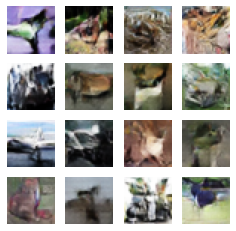

Time for training : 19543 sec


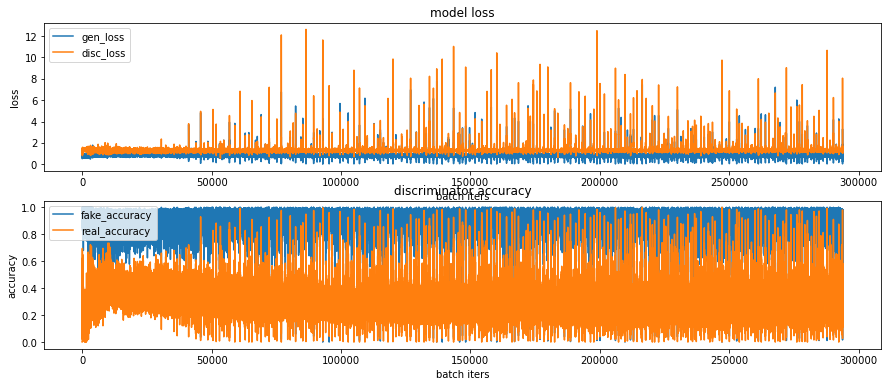

CPU times: user 5h 30min 39s, sys: 5min 54s, total: 5h 36min 34s
Wall time: 5h 25min 51s


In [31]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/training_history 경로에 생성되고 있다.

학습이 끝난 후 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만들어 보자. 더욱 생생한 학습 진행 과정을 확인해 볼 수 있을 것이다.

GIF 파일은 우리가 오래전에 import 해놓았던 `imageio` 라이브러리를 활용해 만들 수 있다.<br>
`imageio.get_writer`를 활용해서 파일을 열고, 거기에 `append_data`로 이미지를 하나씩 붙여나가는 방식이다.<br>
아래 코드가 무사히 실행되면, `fasion_mnist_dcgan.gif` 파일이 저장되어 있는 것을 확인할 수 있다!

In [33]:
anim_file = os.getenv('HOME')+'/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


![cifar10_dcgan.gif](./dcgan_newimage/cifar10/cifar10_dcgan.gif)
알아보기 어렵지만, 첫 사진은 새처럼 보인다. 중간중간 고라니의 사진도 보이는 것 같다.

### STEP 7. (optional) GAN 훈련 과정 개선하기
---
* STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해보자.
* 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출한다.

(참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것이다.

* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
* [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
* [Improved Techniques for Training GANs(paper)](https://papers.nips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf)

#### learning rate가 1e-4일때

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
def make_generator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    
    return model

In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [10]:
noise = tf.random.normal([1, 100])

In [11]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

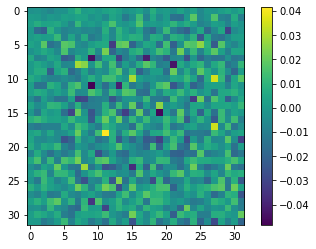

In [12]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [13]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [15]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00164162]], dtype=float32)>

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [22]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2) # 정규화 해주었다.
        plt.axis('off')

    plt.savefig('{}/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/generated_samples2/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/training_history2/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [25]:
checkpoint_dir = os.getenv('HOME')+'/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/training_checkpoints2'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [29]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

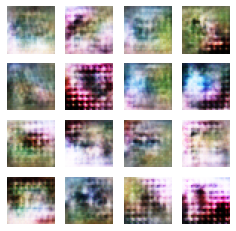

Time for training : 543 sec


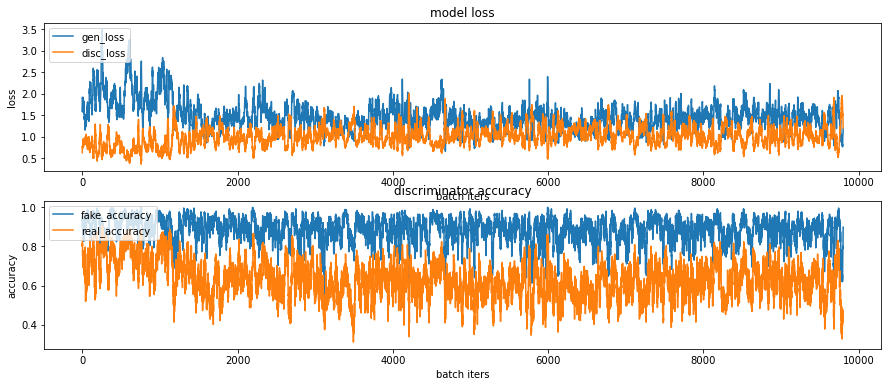

CPU times: user 9min 21s, sys: 12.6 s, total: 9min 34s
Wall time: 9min 4s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

#### learning rate가 0.0002, momentum이 0.5일때

In [57]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

In [58]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [59]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [60]:
def make_generator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape Layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    
    return model

In [61]:
generator = make_generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 128)        

In [62]:
noise = tf.random.normal([1, 100])

In [63]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

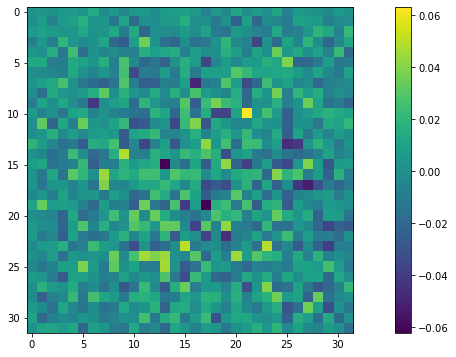

In [64]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [65]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [66]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)             

In [67]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00013128]], dtype=float32)>

In [68]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [69]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [70]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [71]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [73]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [74]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [75]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [76]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2) # 정규화 해주었다.
        plt.axis('off')

    plt.savefig('{}/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/generated_samples3/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [77]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/training_history3/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [78]:
checkpoint_dir = os.getenv('HOME')+'/AIFFEL/Exploration/E12_Gan/dcgan_newimage/cifar10/training_checkpoints3'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [79]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [80]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

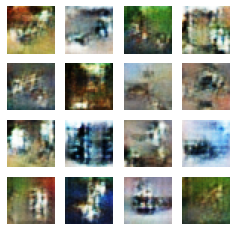

Time for training : 538 sec


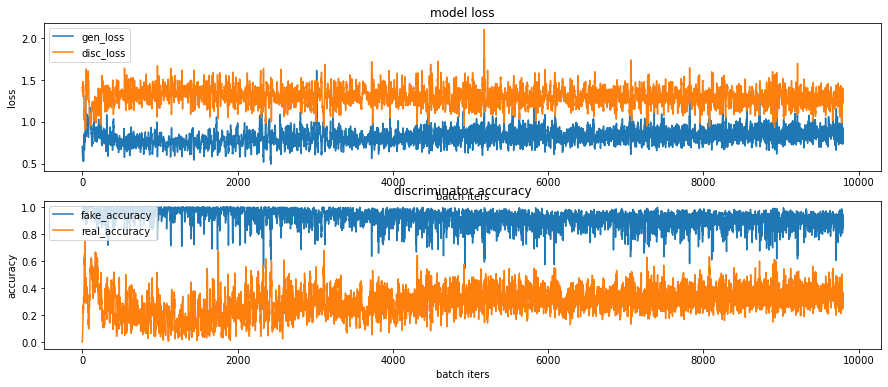

CPU times: user 9min 6s, sys: 10.4 s, total: 9min 16s
Wall time: 8min 58s


In [81]:
%%time
train(train_dataset, EPOCHS, save_every)

#### 두가지 파라미터 비교

learning rate가 1e-4일때와 learning rate가 0.0002, momentum이 0.5일때의 성능을 비교해보았다.
정확한 성능 비교를 위해 에폭은 50으로 동일하게 만들었다.

위에 있는 차트와 사진이 __learning rate가 1e-4일때__이고, <br>
아래에 있는 차트와 사진이 __learning rate가 0.0002, momentum이 0.5일때__이다.

<img src="./image/compare.png" />

<img src="./image/compare2.png" />

한눈에 봐도 아래에 있는 사진이 잘 나온 것을 확인 할 수 있다. 즉, 하이퍼파라미터가 __learning rate: 0.0002, momentum: 0.5일때__ 더 좋은 성능을 발휘한다 라고 결론지을 수 있다.

위에 결과를 근거로 제출할 프로젝트 모델의 하이퍼파라미터를 __learning rate: 0.0002, momentum: 0.5__로 정하여 GAN 훈련 과정을 개선하였다.

### 회고
---
* 첨에 영석님이 에폭을 1800으로 시도했다는 이야기를 듣고 에폭 1500으로 시도하게 되었다.(이후 영석님은 3000번까지 해보셨다고 한다.)
* 그러나 생성이미지가 선명하지 않아서 구글링을 통해 파라미터를__learning rate: 0.0002, momentum: 0.5__로 수정하였다.
* 확실히 파라미터를 변경하니 괜찮은 이미지가 생성되었다.
* GAN이 어렵다는 이야기를 많이 듣긴 했는데 확실히 난이도가 있는 프로젝트였으며, 동시에 시간도 많이 들었다

### 루브릭
---
* GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.<br>
(_오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다._)

    * __선명하고 구별할 만한 가짜 이미지 생성에 성공하였다.__

* 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.<br>
( _gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다._)
    
    * __생성이미지의 품질이 서서히 향상되는 gif를 첨부하였고 fake accuracy가 추세적으로 0.5를 향해 하향하고 있다.__

* 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.<br>
(_제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다._)
    
    * __learning rate가 1e-4일때와 learning rate가 0.0002, momentum이 0.5일때의 성능을 비교하여 더 좋은 성능을 내는 파라미터를 선택하였다. 그 과정을 시각적으로 입증하였다.__